In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, to_graphviz

seed = np.random.seed(0)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("wage.csv")

In [3]:
df

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,Never Married,White,Below HS Grad,Middle Atlantic,Industrial,Good,No,4.318063,75.043154
1,2004,24,Never Married,White,College Grad,Middle Atlantic,Information,Very Good,No,4.255273,70.476020
2,2003,45,Married,White,Some College,Middle Atlantic,Industrial,Good,Yes,4.875061,130.982177
3,2003,43,Married,Asian,College Grad,Middle Atlantic,Information,Very Good,Yes,5.041393,154.685293
4,2005,50,Divorced,White,HS Grad,Middle Atlantic,Information,Good,Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,Married,White,Some College,Middle Atlantic,Industrial,Very Good,Yes,5.041393,154.685293
2996,2007,30,Married,White,HS Grad,Middle Atlantic,Industrial,Very Good,No,4.602060,99.689464
2997,2005,27,Married,Black,Below HS Grad,Middle Atlantic,Industrial,Good,No,4.193125,66.229408
2998,2005,27,Never Married,White,Some College,Middle Atlantic,Industrial,Very Good,Yes,4.477121,87.981033


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


In [5]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921506
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [6]:
df.shape

(3000, 11)

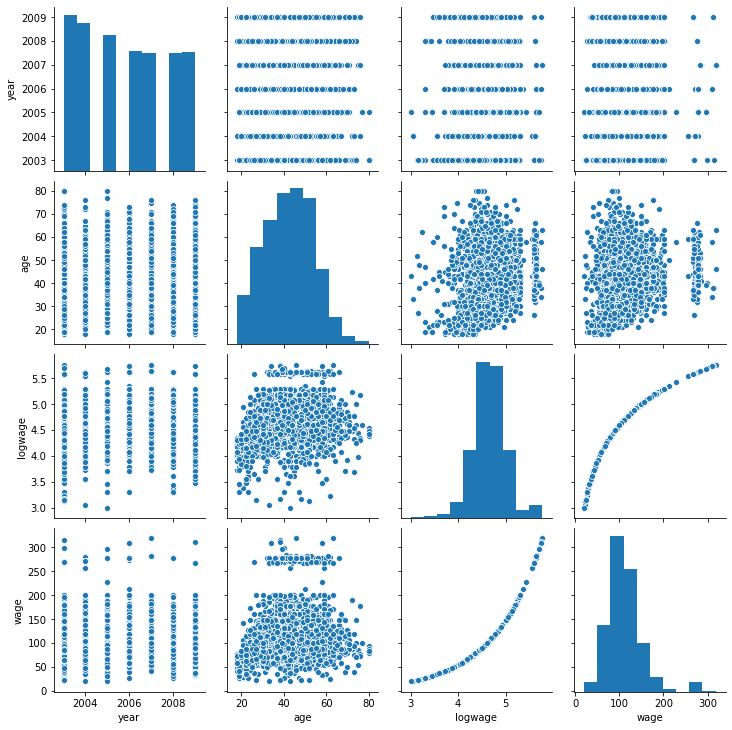

In [7]:
sns.pairplot(df)
plt.show()

In [8]:
df.isnull().sum()

year          0
age           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

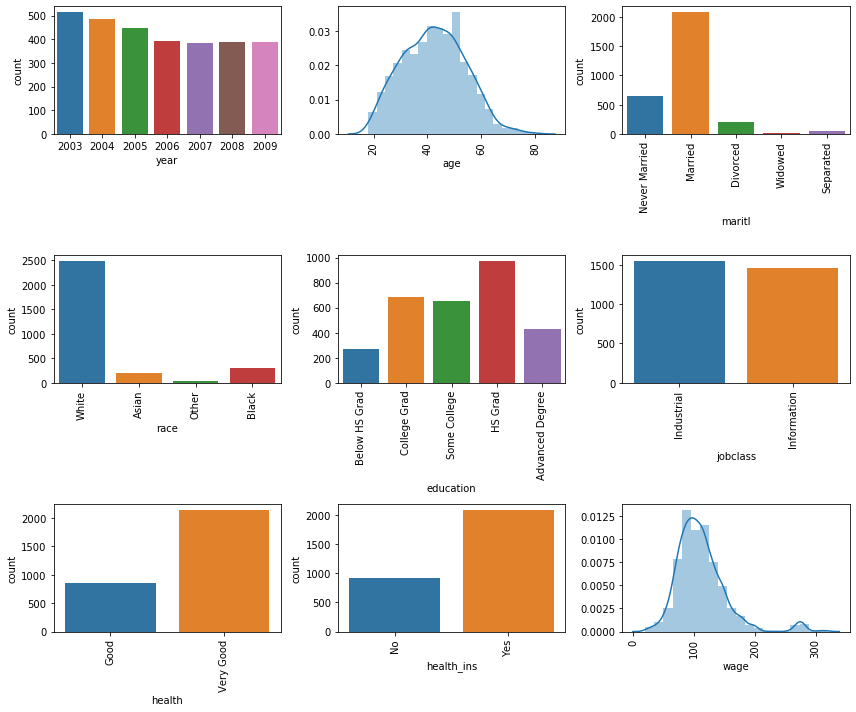

In [9]:
plt.figure(figsize=(12,10))

plt.subplot(3,3,1)
sns.countplot(x='year', data=df)

plt.subplot(3,3,2)
plt.xticks(rotation=90)
sns.distplot(a=df['age'], bins=20)

plt.subplot(3,3,3)
plt.xticks(rotation=90)
sns.countplot(x='maritl', data=df)

plt.subplot(3,3,4)
plt.xticks(rotation=90)
sns.countplot(x='race', data=df)

plt.subplot(3,3,5)
plt.xticks(rotation=90)
sns.countplot(x='education', data=df)

plt.subplot(3,3,6)
plt.xticks(rotation=90)
sns.countplot(x='jobclass', data=df)

plt.subplot(3,3,7)
plt.xticks(rotation=90)
sns.countplot(x='health', data=df)

plt.subplot(3,3,8)
plt.xticks(rotation=90)
sns.countplot(x='health_ins', data=df)

plt.subplot(3,3,9)
plt.xticks(rotation=90)
sns.distplot(a=df['wage'], bins=20)

plt.tight_layout()

In [10]:
df['region'].value_counts()

Middle Atlantic    3000
Name: region, dtype: int64

In [11]:
df['health'].value_counts()

Very Good    2142
Good          858
Name: health, dtype: int64

In [12]:
df['health_ins'].value_counts()

Yes    2083
No      917
Name: health_ins, dtype: int64

In [13]:
df = df.drop(['year','region','logwage'], axis=1)

In [14]:
df

,age,maritl,race,education,jobclass,health,health_ins,wage
0,18,Never Married,White,Below HS Grad,Industrial,Good,No,75.043154
1,24,Never Married,White,College Grad,Information,Very Good,No,70.476020
2,45,Married,White,Some College,Industrial,Good,Yes,130.982177
3,43,Married,Asian,College Grad,Information,Very Good,Yes,154.685293
4,50,Divorced,White,HS Grad,Information,Good,Yes,75.043154
...,...,...,...,...,...,...,...,...
2995,44,Married,White,Some College,Industrial,Very Good,Yes,154.685293
2996,30,Married,White,HS Grad,Industrial,Very Good,No,99.689464
2997,27,Married,Black,Below HS Grad,Industrial,Good,No,66.229408
2998,27,Never Married,White,Some College,Industrial,Very Good,Yes,87.981033


In [15]:
df.corr()

,age,wage
age,1.000000,0.195637
wage,0.195637,1.000000


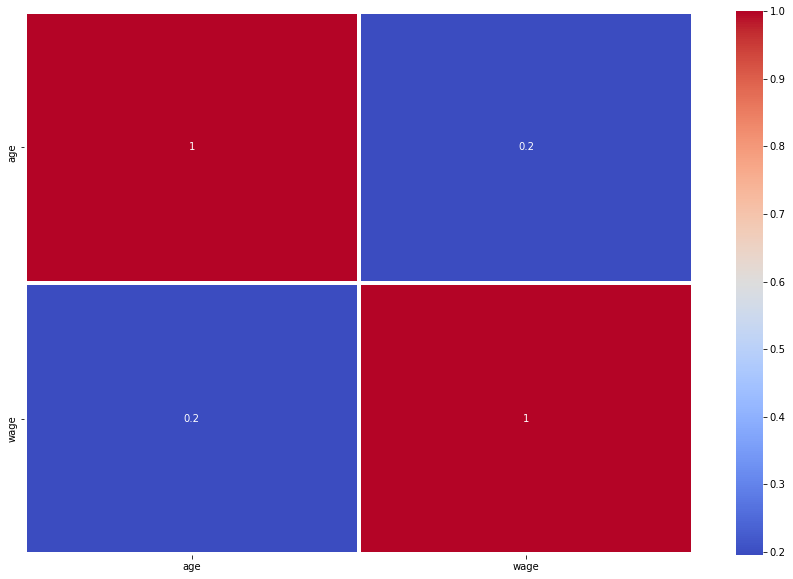

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(data=df.corr(),cmap="coolwarm",annot=True,linewidths=4,fmt='.2g')
plt.show()

In [17]:
df1 = pd.get_dummies(data=df,drop_first=True)

In [18]:
df1

,age,wage,maritl_Married,maritl_Never Married,maritl_Separated,maritl_Widowed,race_Black,race_Other,race_White,education_Below HS Grad,education_College Grad,education_HS Grad,education_Some College,jobclass_Information,health_Very Good,health_ins_Yes
0,18,75.043154,0,1,0,0,0,0,1,1,0,0,0,0,0,0
1,24,70.476020,0,1,0,0,0,0,1,0,1,0,0,1,1,0
2,45,130.982177,1,0,0,0,0,0,1,0,0,0,1,0,0,1
3,43,154.685293,1,0,0,0,0,0,0,0,1,0,0,1,1,1
4,50,75.043154,0,0,0,0,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,44,154.685293,1,0,0,0,0,0,1,0,0,0,1,0,1,1
2996,30,99.689464,1,0,0,0,0,0,1,0,0,1,0,0,1,0
2997,27,66.229408,1,0,0,0,1,0,0,1,0,0,0,0,0,0
2998,27,87.981033,0,1,0,0,0,0,1,0,0,0,1,0,1,1


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      3000 non-null   int64  
 1   wage                     3000 non-null   float64
 2   maritl_Married           3000 non-null   uint8  
 3   maritl_Never Married     3000 non-null   uint8  
 4   maritl_Separated         3000 non-null   uint8  
 5   maritl_Widowed           3000 non-null   uint8  
 6   race_Black               3000 non-null   uint8  
 7   race_Other               3000 non-null   uint8  
 8   race_White               3000 non-null   uint8  
 9   education_Below HS Grad  3000 non-null   uint8  
 10  education_College Grad   3000 non-null   uint8  
 11  education_HS Grad        3000 non-null   uint8  
 12  education_Some College   3000 non-null   uint8  
 13  jobclass_Information     3000 non-null   uint8  
 14  health_Very Good        

In [20]:
df2 = df1[['age','maritl_Married','maritl_Never Married','maritl_Separated',
           'maritl_Widowed','race_Black','race_Other', 'race_White','education_Below HS Grad',
           'education_College Grad', 'education_HS Grad','education_Some College','jobclass_Information',
           'health_Very Good','health_ins_Yes','wage']]

In [21]:
df2

,age,maritl_Married,maritl_Never Married,maritl_Separated,maritl_Widowed,race_Black,race_Other,race_White,education_Below HS Grad,education_College Grad,education_HS Grad,education_Some College,jobclass_Information,health_Very Good,health_ins_Yes,wage
0,18,0,1,0,0,0,0,1,1,0,0,0,0,0,0,75.043154
1,24,0,1,0,0,0,0,1,0,1,0,0,1,1,0,70.476020
2,45,1,0,0,0,0,0,1,0,0,0,1,0,0,1,130.982177
3,43,1,0,0,0,0,0,0,0,1,0,0,1,1,1,154.685293
4,50,0,0,0,0,0,0,1,0,0,1,0,1,0,1,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,44,1,0,0,0,0,0,1,0,0,0,1,0,1,1,154.685293
2996,30,1,0,0,0,0,0,1,0,0,1,0,0,1,0,99.689464
2997,27,1,0,0,0,1,0,0,1,0,0,0,0,0,0,66.229408
2998,27,0,1,0,0,0,0,1,0,0,0,1,0,1,1,87.981033


In [22]:
df2.shape

(3000, 16)

In [23]:
X = df2.iloc[:,0:15]
y = df2.iloc[:,15]

In [24]:
X.values, y.values

(array([[18,  0,  1, ...,  0,  0,  0],
        [24,  0,  1, ...,  1,  1,  0],
        [45,  1,  0, ...,  0,  0,  1],
        ...,
        [27,  1,  0, ...,  0,  0,  0],
        [27,  0,  1, ...,  0,  1,  1],
        [55,  0,  0, ...,  0,  0,  1]], dtype=int64),
 array([ 75.04315402,  70.47601965, 130.9821774 , ...,  66.22940829,
         87.98103279,  90.48191336]))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [26]:
xgbmodel = XGBRegressor(objective='reg:squarederror',seed=seed,n_estimators=500)

In [27]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric=['rmse'],early_stopping_rounds=10)

[0]	validation_0-rmse:110.355
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:101.111
[2]	validation_0-rmse:92.8253
[3]	validation_0-rmse:85.5596
[4]	validation_0-rmse:79.1413
[5]	validation_0-rmse:73.4965
[6]	validation_0-rmse:68.5458
[7]	validation_0-rmse:64.1959
[8]	validation_0-rmse:60.4596
[9]	validation_0-rmse:57.1968
[10]	validation_0-rmse:54.3286
[11]	validation_0-rmse:51.8956
[12]	validation_0-rmse:49.8162
[13]	validation_0-rmse:48.01
[14]	validation_0-rmse:46.4494
[15]	validation_0-rmse:45.1879
[16]	validation_0-rmse:44.0658
[17]	validation_0-rmse:43.1274
[18]	validation_0-rmse:42.3397
[19]	validation_0-rmse:41.6776
[20]	validation_0-rmse:41.1213
[21]	validation_0-rmse:40.6352
[22]	validation_0-rmse:40.2465
[23]	validation_0-rmse:39.8954
[24]	validation_0-rmse:39.6193
[25]	validation_0-rmse:39.3575
[26]	validation_0-rmse:39.14
[27]	validation_0-rmse:38.9414
[28]	validation_0-rmse:38.8062
[29]	validation_0-rmse:38.6582
[30]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [28]:
y_pred = xgbmodel.predict(X_test)

In [29]:
y_pred

array([105.90574 ,  99.03603 , 121.368576, 111.73076 ,  81.158516,
       137.70918 , 121.94942 , 121.003784, 127.8859  , 141.64183 ,
       141.68665 ,  97.15011 , 119.189865, 127.8859  , 130.91753 ,
       136.31696 ,  94.94518 ,  93.43576 , 143.97942 ,  83.62316 ,
        82.54041 ,  81.51829 , 120.719185, 118.65126 , 127.8859  ,
       110.576225, 103.52351 , 132.9881  , 140.91653 , 106.28404 ,
       116.266685, 111.73076 , 123.88681 , 116.66803 , 128.33786 ,
        92.345795, 155.5887  , 154.85867 , 119.77087 , 122.42235 ,
       132.81647 , 156.314   , 121.94942 ,  94.53172 , 137.70918 ,
       103.566086,  84.995384,  81.10837 , 100.32444 ,  60.830708,
       106.86067 , 111.676765,  87.33421 , 155.34625 ,  63.46301 ,
        94.43613 ,  60.817436, 121.79206 , 110.33054 , 128.74272 ,
        81.99121 ,  96.34081 , 147.24135 , 107.403946,  76.30796 ,
       118.104034, 110.47009 ,  86.346214,  75.30227 , 131.85767 ,
       117.647766,  86.670044, 133.36371 , 139.76408 , 101.574

In [30]:
mse = mean_squared_error(y_test,y_pred)
mse

1397.5202271118583

In [31]:
rmse = np.sqrt(mse)
rmse

37.383421821869895

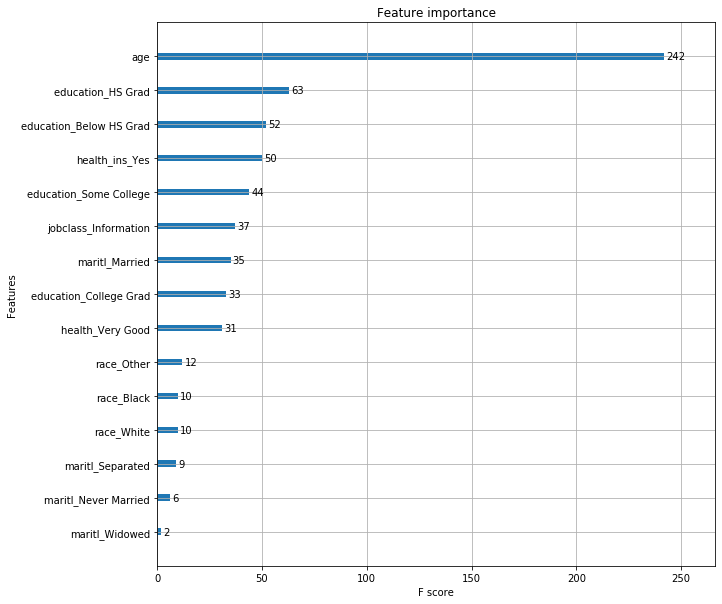

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgbmodel, ax=ax)
plt.show()

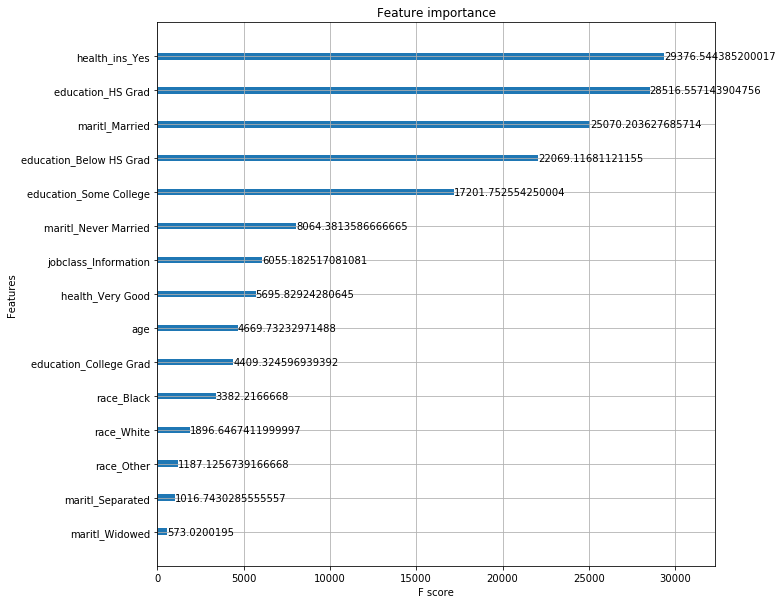

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgbmodel, ax=ax, importance_type='gain')
plt.show()

In [34]:
r2_score(y_test,y_pred)

0.3238721345053335

In [35]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [36]:
cv = cross_val_score(xgbmodel,X,y,scoring='r2',cv=5,n_jobs=-1)

In [37]:
cv

array([0.32892744, 0.32224795, 0.22598323, 0.34639901, 0.31001609])

In [38]:
np.mean(cv)

0.3067147452142696

In [39]:
np.std(cv)

0.042042841760520165